# Trading model for bitcoin prices 

### (Summary)

In this document, I show an example of collecting daily updated data of bitcoin prices from a website, and the implementation of ARIMA models to forecast future bitcoin prices. So far, the best model works on weekly resampled data

### Workflow

1. Collecting data
2. Exploratory data analysis
3. Preprocessing
4. Evaluate stationarity (Augmented Dickey-Fuller Test)
5. Visualization on autocorrelation and partial autocorrelation
6. Find best ARIMA model
7. Train model
8. Model diagnostics
9. Forecast

### 1. COLLECTING DATA

The data is collected from the website https://coinmarketcap.com and was stored as a pandas dataframe. The collected historical prices (USD) ranged from January 2017 to current date.

In [1]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from scipy.stats import pearsonr


# 1. COLLECTING DATA

# Get string for today's date

def get_end_url():
    """Retrieves today's date for url in website"""
    """Requires to import date from datetime"""
    today = str(date.today()).replace("-","")
    
    return today

# Define url for scraping
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20170101&end={}".format(get_end_url())

# Parse table data into dataframe
df = pd.read_html(url)

# Df is a list of dataframes. df[2] is the dataframe we work with
df = df[2]

# Convert "Date" column into a datetime datatype
df["Date"] = pd.to_datetime(df.Date)

# Make index into a datetime index
df.index = pd.DatetimeIndex(df.Date.values)

# Reassign columns
df.columns = ["date","open","high","low","close","volume","market_cap"]

# Add "market_cap/volume" column into dataframe
df["market_cap/volume"] = df.market_cap/df.volume

# sort index values
df = df.sort_index()




### 2. EXPLORATORY DATA ANALYSIS

Exploratory data analysis is outlined as follows:

2.1. Data profiling
2.2. Open, high and close prices
2.3. Resampling of close price into weekly, montly and quarterly data
2.4. Visualization of time series of close price and volume 
2.5. Correlation between close price and volume
2.6. OLS on market capitalization and volume

#### 2.1 Data Profiling

The dataframe's tail and info show that the collected data is up to date. Each observation (row) corrresponds to each day, where "open" refers to the starting price on that day, "high" is the highest price during the day, low is the lowest price, and close is the price at the end of the day. Volume represents the total number of bitcoin transactions during the day, and market price is the money invested in transactions. 

The information collected from the dataframe shows no missing values, a total of 7 columns with 1219 entries, and all data is numeric. Upfollowing, some descriptive statistics on the data is shown. In here, we collect insight on the data on quantiles, range, mean and standard deviation.





In [2]:
# View the dataframe's five most current observations
df.tail()


,date,open,high,low,close,volume,market_cap,market_cap/volume
2020-05-08,2020-05-08,9936.16,9996.74,9767.17,9842.67,51780748042,180804859844,3.491739
2020-05-09,2020-05-09,9840.91,9913.86,9580.64,9593.90,46566121841,176251395673,3.784970
2020-05-10,2020-05-10,9591.17,9595.58,8395.11,8756.43,63325279337,160884755211,2.540609
2020-05-11,2020-05-11,8755.54,9033.47,8374.32,8601.80,57119858802,158059235276,2.767150
2020-05-12,2020-05-12,8610.39,8949.90,8569.64,8804.48,42142717533,161791577301,3.839135


In [3]:
# Inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1228 entries, 2017-01-01 to 2020-05-12
Data columns (total 8 columns):
date                 1228 non-null datetime64[ns]
open                 1228 non-null float64
high                 1228 non-null float64
low                  1228 non-null float64
close                1228 non-null float64
volume               1228 non-null int64
market_cap           1228 non-null int64
market_cap/volume    1228 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 86.3 KB


In [4]:
# Show descriptive statistics
df.describe()

,open,high,low,close,volume,market_cap,market_cap/volume
count,1228.000000,1228.000000,1228.000000,1228.000000,1.228000e+03,1.228000e+03,1228.000000
mean,6511.631979,6688.647101,6321.452647,6517.863673,1.159933e+10,1.134264e+11,26.085570
std,3413.856469,3538.374805,3257.038273,3410.875697,1.232253e+10,5.968649e+10,29.695993
min,775.180000,823.310000,755.760000,777.760000,6.085170e+07,1.251914e+10,1.370672
25%,3877.867500,3948.985000,3796.705000,3882.672500,3.109930e+09,6.745112e+10,7.820896
50%,6650.390000,6791.735000,6544.365000,6662.865000,6.207637e+09,1.154896e+11,19.445942
75%,8704.770000,8879.537500,8472.440000,8710.272500,1.712695e+10,1.537912e+11,30.220743
max,19475.800000,20089.000000,18974.100000,19497.400000,7.415677e+10,3.265025e+11,243.779187


#### 2.1 Open, high and closing prices


Next step is to visualize the price of bitcoins. First, the behavior of open, high, and close price are shown.
In the graph, we observe that the highest peak on bitcoin price was during January 2018 with a peak of 20.000 USD. Another peak is observed in the end of June, 2019. In case the reader is interested, during December 2017 and January 2018, there was the so called "cryptocurrency crash" [1]. 

[1] https://en.wikipedia.org/wiki/2018_cryptocurrency_crash

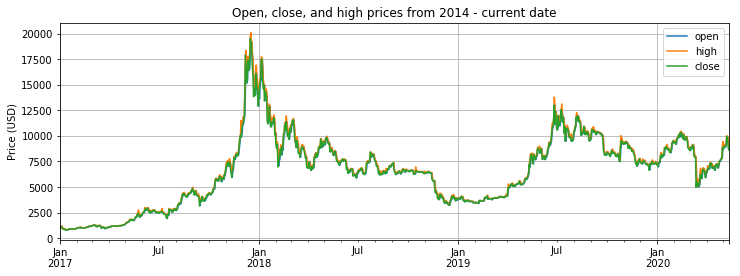

In [5]:
# Define list of columns to visualize
vis1 = ["open","high","close"]

# Visualize open, close, high on daily data
df[vis1].plot(figsize=(12,4))
plt.title("Open, close, and high prices from 2014 - current date")
plt.ylabel("Price (USD)")
plt.grid()
plt.show()

#### 2.3. Resampling of close price into weekly, montly and quarterly data

Next, the data was resampled to weeks, months and quarters, and it is visualized below. Resampled data helps to visualize trends within the data. 

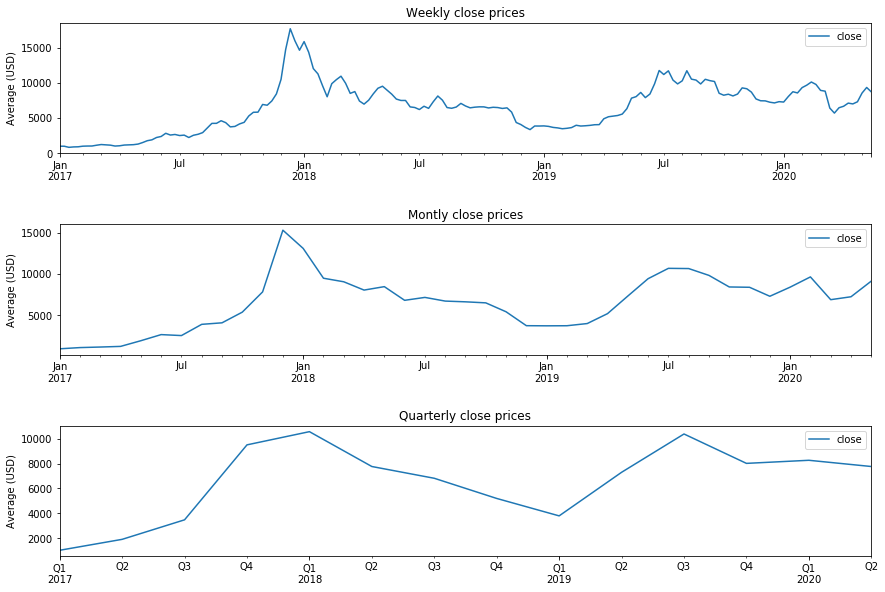

In [6]:
# 2.1 Resampling dataframe and visualize resampled data.

# Create resampled dataframe into weekly data, "monthly", "quarterly"
dfw = df.resample("W").mean()

# Resample dataframe into monthly data
dfm = df.resample("M").mean()

# Create resampled dataframe into quarterly data
dfq = df.resample("Q-DEC").mean()


# Create plots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (12, 8))
plt.tight_layout(h_pad = 5)
# Plot weekly data
dfw.close.plot(ax = ax1, legend = True)
ax1.set_title("Weekly close prices")
ax1.set_ylabel("Average (USD)")

# Plot monthly data
dfm.close.plot(ax = ax2, legend = True)
ax2.set_title("Montly close prices")
ax2.set_ylabel("Average (USD)")

# Plot Quarterly data
dfq.close.plot(ax = ax3, legend = True)
ax3.set_title("Quarterly close prices")
ax3.set_ylabel("Average (USD)")
plt.show()

 We will see if there is a correlation between market capitalization and total volume.

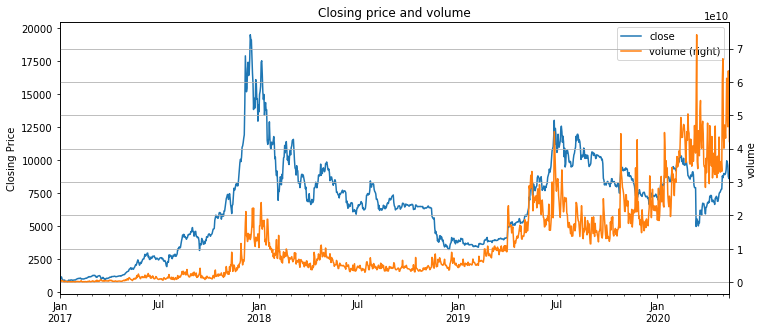

In [7]:
# CANDLE STICK THEORY

# Create plots

plt.figure(figsize=(12,5))
plt.title("Closing price and volume")
plt.ylabel("Closing Price")
df.close.plot(legend = True)
df.volume.plot(secondary_y = ["volume"],legend = True)
plt.grid()
plt.ylabel("volume")
plt.show()


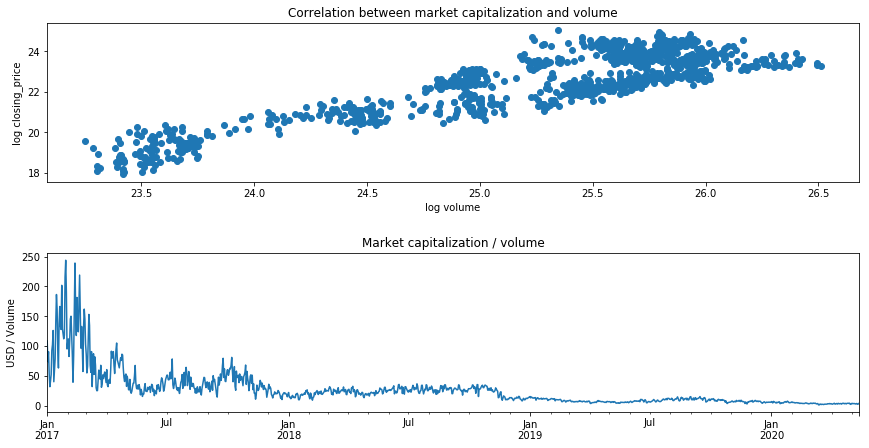

In [8]:
market_cap = np.log(df.market_cap.values)
volume = np.log(df.volume.values)
mc_per_volume = df["market_cap/volume"]

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,6))
plt.tight_layout(h_pad = 5)
ax1.set_title("Correlation between market capitalization and volume")
ax1.scatter(market_cap,volume)
ax1.set_xlabel("log volume")
ax1.set_ylabel("log closing_price")

df["market_cap/volume"].plot(ax = ax2)
ax2.set_title("Market capitalization / volume")
ax2.set_ylabel("USD / Volume")
plt.show()

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Text(74.75,0.5,'Residual')

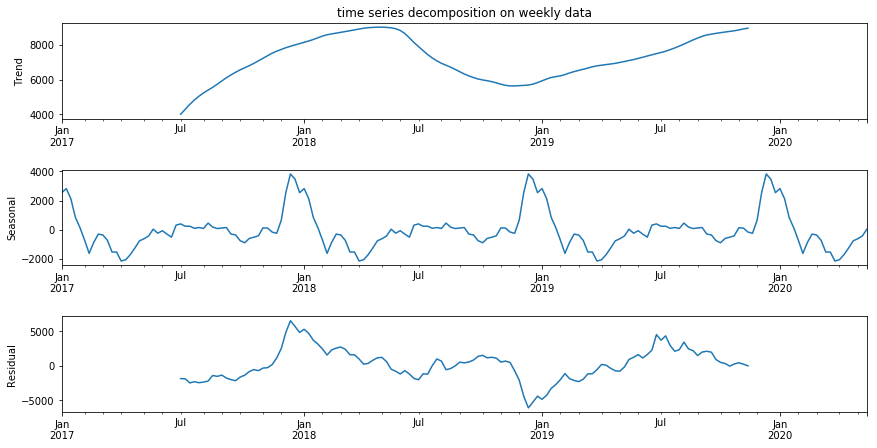

In [9]:
# SEASONAL DECOMPOSITION OF RESAMPLED DATA
from statsmodels.tsa.seasonal import seasonal_decompose

# Time series decomposition on weekly data
resw = seasonal_decompose(dfw.high)

# Initiate figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (12,6))

# Set tight layout for figure
plt.tight_layout(h_pad = 3)

# set plot title
ax1.set_title("time series decomposition on weekly data")

# Plot trend in figure
resw.trend.plot(ax = ax1)
ax1.set_ylabel("Trend")

# Plot seasonality
resw.seasonal.plot(ax = ax2)
ax2.set_ylabel("Seasonal")

# Plot residuals
resw.resid.plot(ax = ax3)
ax3.set_ylabel("Residual")






In [10]:
import statsmodels.api as sm

X = sm.add_constant(df['market_cap'].apply(np.log))
model = sm.OLS(df.close,X).fit()
print(model.summary())
print(model.params)

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     6669.
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        12:58:26   Log-Likelihood:                -10588.
No. Observations:                1228   AIC:                         2.118e+04
Df Residuals:                    1226   BIC:                         2.119e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.026e+05   1336.119    -76.755      0.0

/home/diego/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Data preprocessing for model

In this section, we test for stationarity through the "Augmented Dickey-Fuller test". The data is stationary when its mean and standard deviation do not change in time. The test was performed on weekly and monthly data. When the data is not stationary, we need to transform it so that it is stationary. Common approaches are differentiation, logarithm, or square root.

Augmented Dickey-Fuller test showed that the differentiated data is stationary, achieving p-values of 0.000002 for weekly high prices, and 0.000230 for monthly data.

Dickey–Fuller test on close price, weekly data: p=0.161772
Dickey–Fuller test on close price, monthly data: p=0.107043

After differentiation:

Dickey–Fuller test on high price, weekly data: p=0.000001
Dickey–Fuller test on high price, monthly data: p=0.000218


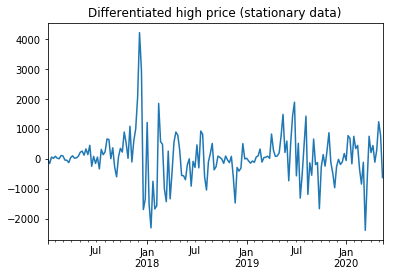

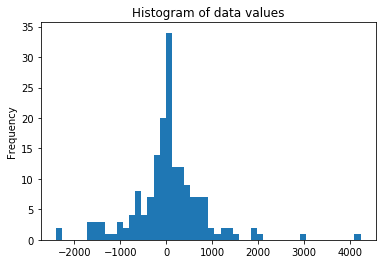

In [11]:
# TEST FOR STATIONARITY ON WEEKLY DataFrame
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Print p-value for Augmented Dickey-Fuller test
print("Dickey–Fuller test on close price, weekly data: p=%f" % adfuller(dfw.high)[1])
print("Dickey–Fuller test on close price, monthly data: p=%f" % adfuller(dfm.high)[1])

# Do prior step again, but after simple differentiation
print("")
print("After differentiation:")
print("")
print("Dickey–Fuller test on high price, weekly data: p=%f" % adfuller(dfw.high.diff().dropna())[1])
print("Dickey–Fuller test on high price, monthly data: p=%f" % adfuller(dfm.high.diff().dropna())[1])

# Define data to test

test = dfw.close.diff().dropna()

# See how stationary data looks like
test.plot()
plt.title("Differentiated high price (stationary data)")
plt.show()

test.plot(kind = "hist", bins = 50)
plt.title("Histogram of data values")
plt.show()

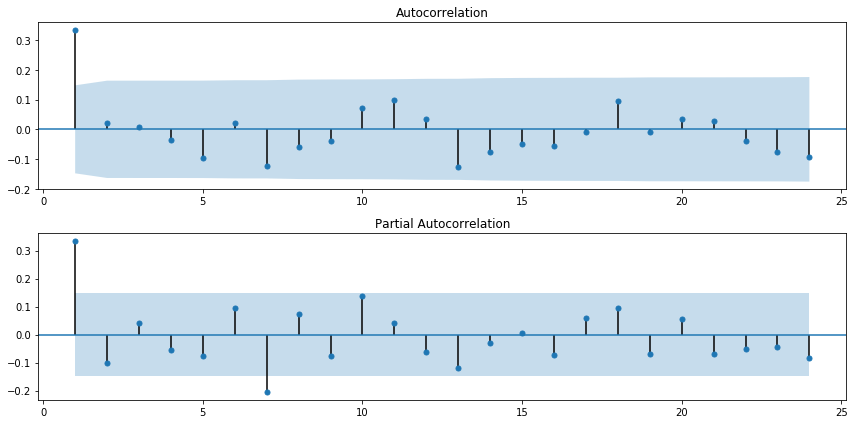

In [12]:
# Plot correlation and autocorrelation function

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,6))
plot_acf(test, lags = 24, zero = False, ax = ax1)
plot_pacf(test, lags = 24, zero = False, ax = ax2)
plt.tight_layout()
plt.show()

In [13]:
# FINDING THE BEST SARIMAX MODEL FOR WEEKLY FORECAST ON BITCOIN PRICE
import statsmodels.api as sm

order_aic_bic = []
exog = dfw[["market_cap","volume"]]

# Loop over p values from 0-2
for p in range(0,3):
    # Loop over q values from 0-2
    for q in range(0,3):

        try:
            # create and fit SARIMAX(p,1,q) model
            model = sm.tsa.statespace.SARIMAX(dfw.high, order=(p,1,q), exog = exog, freq = "W")
            
            results = model.fit(disp = False, maxiter=200)
            
            mae = np.mean(np.abs(results.resid))

            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic, mae))

        except:
            order_aic_bic.append((p, q, None, None))

aic_bic_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC', "mae"])

print("Sorted by AIC")
print(aic_bic_df.sort_values("mae").head())
print("Sorted by BIC")
print(aic_bic_df.sort_values("mae").head())



/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conv

Sorted by AIC
   p  q          AIC          BIC        mae
8  2  2  2201.423302  2223.616690  82.445004
6  2  0  2202.494588  2218.347008  82.471961
1  0  1  2201.387770  2214.069706  82.657059
4  1  1  2203.564288  2219.416708  82.701445
5  1  2  2205.370338  2224.393242  82.741234
Sorted by BIC
   p  q          AIC          BIC        mae
8  2  2  2201.423302  2223.616690  82.445004
6  2  0  2202.494588  2218.347008  82.471961
1  0  1  2201.387770  2214.069706  82.657059
4  1  1  2203.564288  2219.416708  82.701445
5  1  2  2205.370338  2224.393242  82.741234


/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [14]:
# IMPLEMENTATION OF FINAL MODEL FOR WEEKLY FORECAST ON BITCOIN PRICE

# Define "p" and "q" for the final model
res = aic_bic_df.sort_values("mae").iloc[0,0:2].values

p_finalmodel = int(res[0])
q_finalmodel = int(res[1])

# Declare a variable for the order of the model
order = (p_finalmodel,1,q_finalmodel)

# Instantiate model
model = sm.tsa.statespace.SARIMAX(dfw.high, order = order, exog = exog, freq = "W")

# Fit model
results = model.fit(disp=False)

# print results
print(results.summary())



                           Statespace Model Results                           
Dep. Variable:                   high   No. Observations:                  177
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1093.712
Date:                Wed, 13 May 2020   AIC                           2201.423
Time:                        12:58:27   BIC                           2223.617
Sample:                    01-01-2017   HQIC                          2210.425
                         - 05-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
market_cap  5.551e-08   3.41e-10    162.827      0.000    5.48e-08    5.62e-08
volume      2.319e-08   2.17e-09     10.697      0.000    1.89e-08    2.74e-08
ar.L1         -0.9664   2.77e-17  -3.49e+16      0.0

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Some facts collected from the results summary table are stated. First we need to know that for the ideal model, there must be no correlation between 95% of the residuals, and they should follow a normal distribution centered at zero.

The Ljung-Box test result (Prob(Q)) null hypothesis indicates there are no correlation in the residuals. If this value is below 0.05, we reject this hypothesis. This statement means we fail to reject the null hypothesis, meaning he residuals from this model are not correlated, and this is good.

The Jarque-Bera (JB) null hypothesis indicates that the residuals are normally distributed. In the case this p-value is below 0.05, we reject the null hypothesis. In our case, our p-value of 0.00 indicates that residuals are not normally distributed. Prior experience suggests this not very bad for the model when we have plenty of data available. 



mae = 82.45


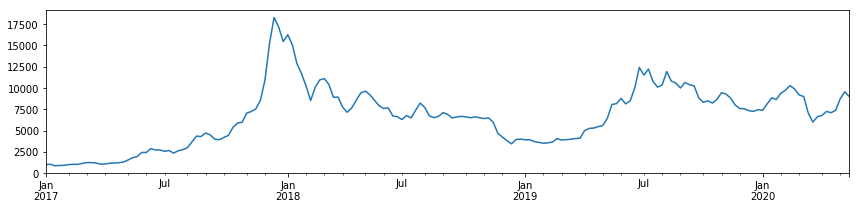

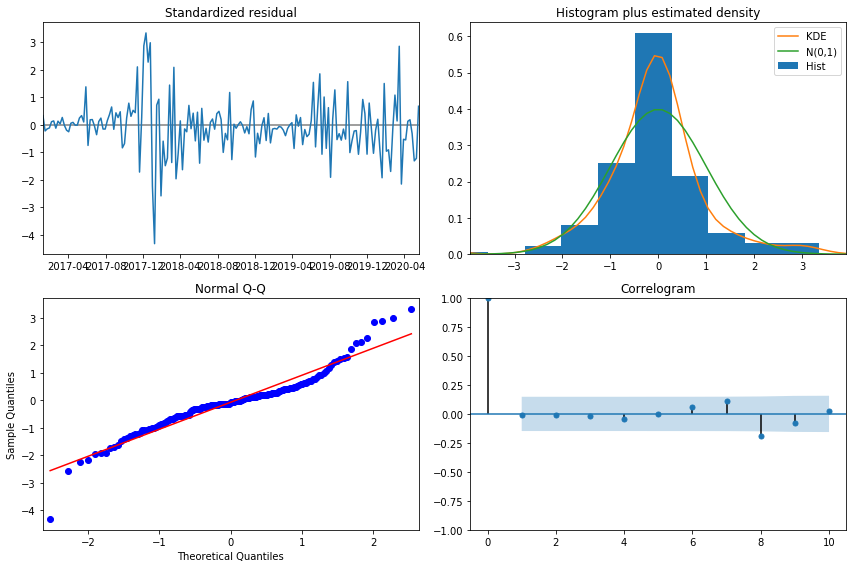

In [15]:
# Compute mean absolute error
mae = np.mean(np.abs(results.resid))
print("mae = {0:.2f}".format(mae))

# Compare mae with variable
dfw.high.plot(figsize = (14.4,3))
plt.show()

# Perform more diagnostics on) the model
results.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

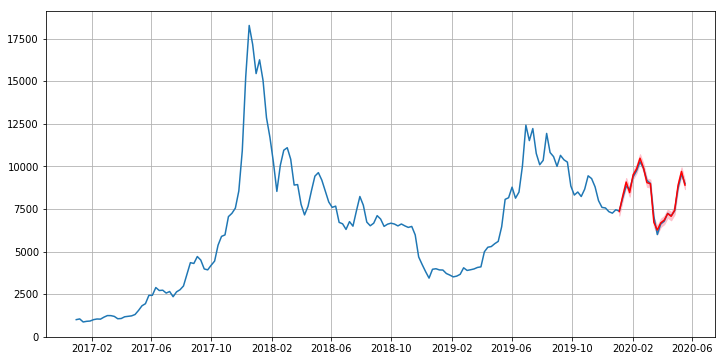

In [16]:
# FORECASTING BITCOIN WEEKLY PRICES

# Compute forecast
forecast = results.get_prediction(start = -20)

# compute forecast mean
mean_forecast = forecast.predicted_mean

# Compute confidence intervals of mean_forecast
confidence_intervals = forecast.conf_int()

# Plot results: initialize figure
plt.figure(figsize = (12,6))

# Plot data
plt.plot(dfw.index, dfw.high, label = "observed")

# plot mean forecast
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.grid()
# shade the area between confidence limits
lower_limits = confidence_intervals["lower high"]
upper_limits = confidence_intervals["upper high"]

plt.fill_between(lower_limits.index, lower_limits,
		 upper_limits, color='pink')


plt.show()

In [17]:
# print current forecast
print(mean_forecast.tail())
print(dfw.tail())

2020-04-19    7077.842196
2020-04-26    7428.372441
2020-05-03    8895.757831
2020-05-10    9710.423108
2020-05-17    8908.586020
Freq: W-SUN, dtype: float64
                   open         high          low        close        volume  \
2020-04-19  6966.381429  7100.707143  6851.087143  6998.520000  3.543902e+10   
2020-04-26  7231.742857  7389.805714  7162.367143  7301.417143  3.539072e+10   
2020-05-03  8372.317143  8735.074286  8291.377143  8544.727143  4.683148e+10   
2020-05-10  9349.450000  9561.375714  9049.971429  9332.714286  5.157486e+10   
2020-05-17  8682.965000  8991.685000  8471.980000  8703.140000  4.963129e+10   

              market_cap  market_cap/volume  
2020-04-19  1.282765e+11           3.684757  
2020-04-26  1.339234e+11           3.821261  
2020-05-03  1.568350e+11           3.514404  
2020-05-10  1.714207e+11           3.381073  
2020-05-17  1.599254e+11           3.303143  


Next prediction for 2020-05-10, bitcoin prices will still go up to app. 9601.2

# DEFINITIVE MODEL: FORCAST MODELS ON DAILY AND WEEKLY PERCENTAGE CHANGE

Having trained our model to forecast values in time, now we want to ellaborate a model that will predict change of prices. This helps to better forecast results as well. So this time we will go quick through the procedures. 

## DAILY FORECAST MODEL

Prior observations on mean average error training arima models showed that exogenous data is required. In order to produce this kind of forecasts, we need the exogenous data of the forecast time frame. Therefore two arima models are implemented to produce forecasts that will serve as input for the actual model. Something else to consider, when building arima forecast models based on daily data, we need a slice from the original data. Therefore, data from 1st of July, 2019 to current data are considered in the model. 

In [18]:
# Obtain dataframe with daily data and percentual changes
dfd_pct_change = pd.DataFrame()

dfd_pct_change["open"] = df.open.pct_change().dropna()*100
dfd_pct_change["high"] = df.high.pct_change().dropna()*100
dfd_pct_change["close"] = df.close.pct_change().dropna()*100
dfd_pct_change["market_cap"] = df.market_cap.pct_change().dropna()*100
dfd_pct_change["volume"] = df.volume.pct_change()*100

# Define the required dataframe to train the model
train_df_d = dfd_pct_change["2019-07-01":date.today()]



p-value for high price stationartiy:  5.892517407682216e-09
p-value for market capitalization stationartiy:  3.7050511195070876e-13
p-value for market volume stationartiy:  4.1709100302765735e-12


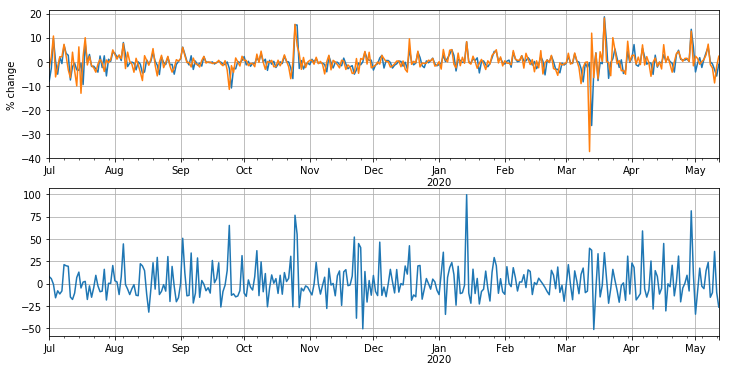

In [19]:
# Test stationarity on high price 
high_dailychange_adfuller = adfuller(train_df_d.high)
market_cap_dailychange_adfuller = adfuller(train_df_d.market_cap)
volume_dailychange_adfuller = adfuller(train_df_d.volume)


# Print p-value from Augmente Dickey-Fuller test 
print("p-value for high price stationartiy: ", high_dailychange_adfuller[1])
print("p-value for market capitalization stationartiy: ", market_cap_dailychange_adfuller[1])
print("p-value for market volume stationartiy: ", volume_dailychange_adfuller[1])


# Look at the stationary data 

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,6))
train_df_d.high.plot(ax = ax1)
train_df_d.market_cap.plot(ax = ax1)
train_df_d.volume.plot(ax = ax2)
ax1.set_ylabel("% change")
ax1.grid()
ax2.grid()
plt.show()



Notice that the change pf market capitalization and high price fluctuate within a similar range. On the contrary, volume changes from around -50% up to 100%. 

CORRELATION AND PARTIAL AUTOCORRELATION PLOTS OF HIGH PRICE


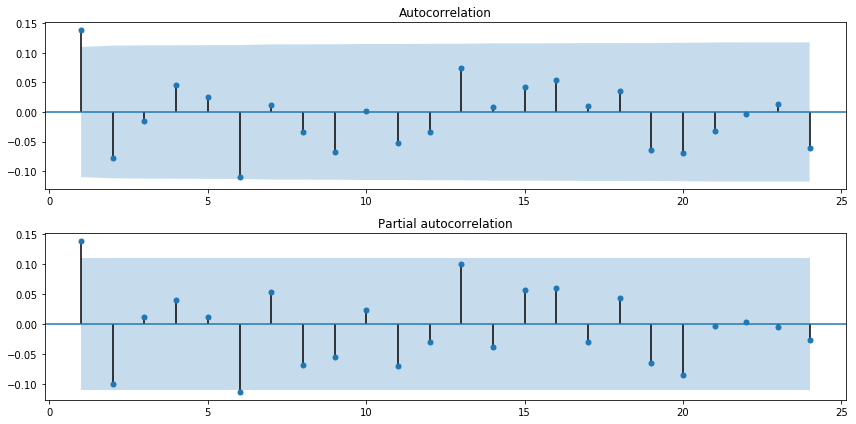

CORRELATION AND PARTIAL AUTOCORRELATION PLOTS OF MARKET CAPITALIZATION


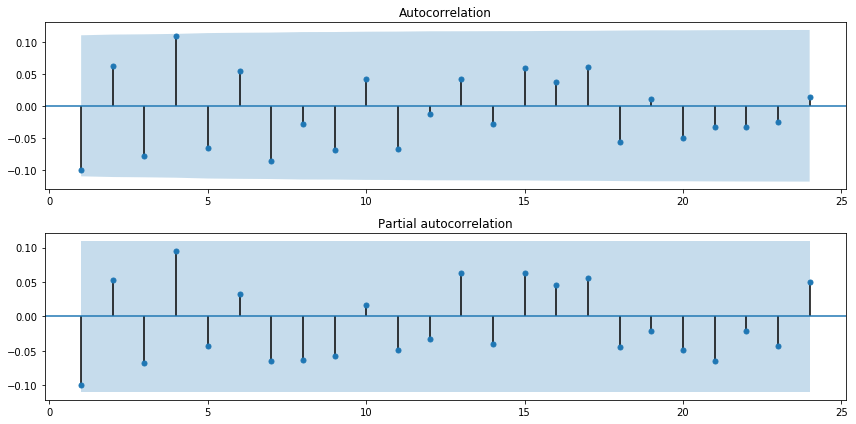

CORRELATION AND PARTIAL AUTOCORRELATION PLOTS OF VOLUME


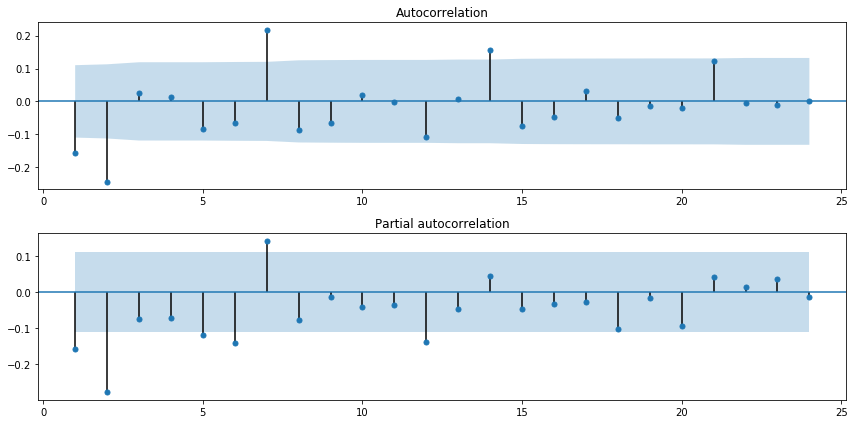

In [20]:


# Check for autocorrelation and partial autocorrelation for high price
print("CORRELATION AND PARTIAL AUTOCORRELATION PLOTS OF HIGH PRICE")
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,6))
plot_acf(train_df_d.high, lags = 24, zero = False, ax = ax1)
plot_pacf(train_df_d.high, lags = 24, zero = False, ax = ax2)
plt.title("Partial autocorrelation")
plt.tight_layout()
plt.show()

# Check for autocorrelation and partial autocorrelation for market_cap
print("CORRELATION AND PARTIAL AUTOCORRELATION PLOTS OF MARKET CAPITALIZATION")
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,6))
plot_acf(train_df_d.market_cap, lags = 24, zero = False, ax = ax1)
plot_pacf(train_df_d.market_cap, lags = 24, zero = False, ax = ax2)
plt.title("Partial autocorrelation")
plt.tight_layout()
plt.show()

print("CORRELATION AND PARTIAL AUTOCORRELATION PLOTS OF VOLUME")
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,6))
plot_acf(train_df_d.volume, lags = 24, zero = False, ax = ax1)
plot_pacf(train_df_d.volume, lags = 24, zero = False, ax = ax2)
plt.title("Partial autocorrelation")
plt.tight_layout()
plt.show()


In [21]:
# Define exogenous data for the model

dfd_pct_change_exog = train_df_d[["market_cap","volume"]] # EXOGENOUS DATA

# Gridsearch through p and q parameters

high_arima_parameters = []
market_cap_arima_parameters = []
volume_arima_parameters = []

for p in range(0,7):
    # Loop over q values from 0-2
    for q in range(0,7):

        try:
            # create and fit SARIMAX(p,1,q) models 
            high_pctd_model = sm.tsa.statespace.SARIMAX(train_df_d.high, order = (p,0,q), exog = dfd_pct_change_exog, freq = "d")
            #market_cap_pctd_model = sm.tsa.statespace.SARIMAX(train_df_d.market_cap, order = (p,0,q), freq = "d")
            
            #volume_pctd_model = sm.tsa.statespace.SARIMAX(train_df_d.volume, order = (p,0,q), freq = "d")

            # fit models
            high_pctd_results = high_pctd_model.fit(disp = False)
            #market_cap_pctd_results = market_cap_pctd_model.fit(disp = False)
            
            #volume_pctd_results = volume_pctd_model.fit(disp = False)
            
            # compute mae
            high_pctd_mae = np.mean(np.abs(high_pctd_results.resid))
            #market_cap_pctd_mae = np.mean(np.abs(market_cap_pctd_results.resid))
            
            #volume_pctd_mae = np.mean(np.abs(volume_pctd_results.resid))

            # Print order and results
            high_arima_parameters.append((p, q, high_pctd_results.aic, high_pctd_results.bic, high_pctd_mae))
            #market_cap_arima_parameters.append((p, q, market_cap_pctd_results.aic, market_cap_pctd_results.bic, market_cap_pctd_mae))
            #volume_arima_parameters.append((p, q, volume_pctd_results.aic, volume_pctd_results.bic, volume_pctd_mae))
            
        except:
            high_arima_parameters.append((p, q, None, None))
            #market_cap_arima_parameters.append((p, q, None, None))
            #volume_arima_parameters.append((p, q, None, None))

            
high_arima_parameters_df = pd.DataFrame(high_arima_parameters, 
                        columns=['p','q','AIC','BIC', "mae"])

#market_cap_arima_parameters_df = pd.DataFrame(market_cap_arima_parameters, 
                                              #columns=['p','q','AIC','BIC', "mae"])

#volume_arima_parameters_df = pd.DataFrame(volume_arima_parameters, 
                                              #columns=['p','q','AIC','BIC', "mae"])

print("Sorted by mae")
print(high_arima_parameters_df.sort_values("mae").head())
#print(market_cap_arima_parameters_df.sort_values("mae").head())
#print(volume_arima_parameters_df.sort_values("mae").head())


/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Lik

Sorted by mae
    p  q          AIC          BIC       mae
14  2  0  1591.793937  1610.588445  1.688743
17  2  3  1587.199662  1617.270876  1.689016
38  5  3  1589.255958  1630.603878  1.704123
46  6  4  1593.233861  1642.099584  1.704682
7   1  0  1600.661947  1615.697554  1.705912


/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


{'fopt': 2.469275651885717, 'gopt': array([ 6.16026128e-03,  1.80043770e-02, -9.81616433e-04,  5.89792415e-03,
       -4.95671548e-04,  2.82747101e-03,  2.22871055e-05,  1.22332056e-03,
       -2.06535278e-04, -4.60519853e-03,  1.20833423e-03,  7.51009033e-05,
        3.83350063e-04, -2.61508752e-03,  1.85926554e-03]), 'fcalls': 880, 'warnflag': 1, 'converged': False, 'iterations': 50}
ARMA (2,0) MODEL
                           Statespace Model Results                           
Dep. Variable:                   high   No. Observations:                  317
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -790.897
Date:                Wed, 13 May 2020   AIC                           1591.794
Time:                        12:58:49   BIC                           1610.588
Sample:                    07-01-2019   HQIC                          1599.301
                         - 05-12-2020                                         
Covariance Type:                  opg    

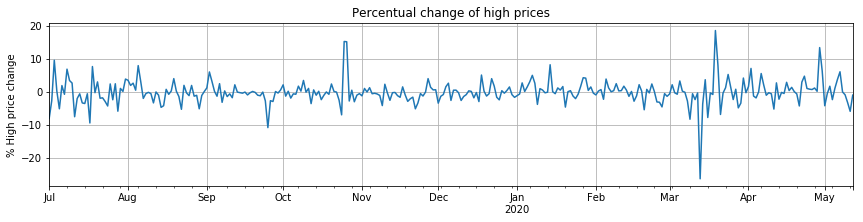

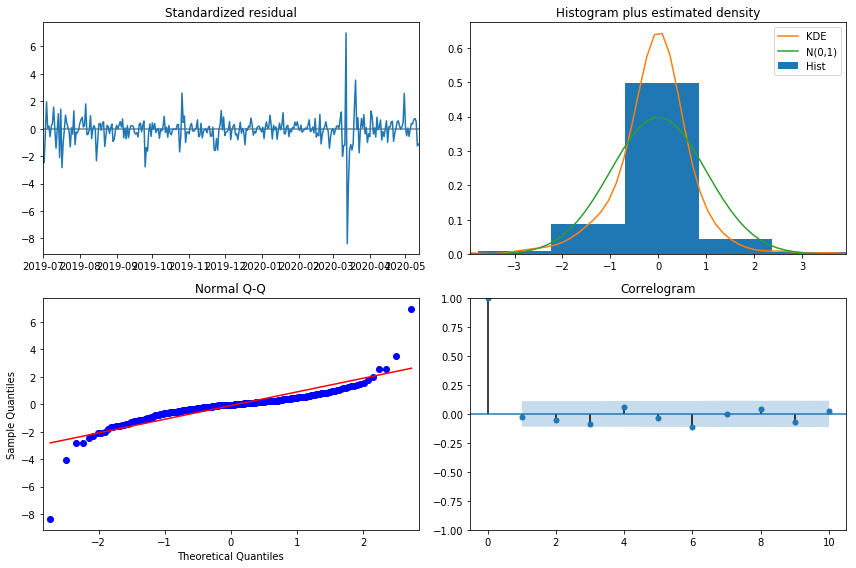

In [22]:
# IMPLEMENTATION OF FINAL MODEL FOR FORECASTING CHANGE

print(high_pctd_results.mle_retvals)

# Define "p" and "q" for the final model
res_d = high_arima_parameters_df.sort_values("mae").iloc[0,0:2].values

p_d = int(res_d[0])
q_d = int(res_d[1])

print("ARMA ({},{}) MODEL".format(p_d,q_d))

# Create final model with chosen parameters 
pct_model_daily = sm.tsa.statespace.SARIMAX(train_df_d.high, order=(p_d,0,q_d), exog = dfd_pct_change_exog, freq = "d")
            
# Fit model
pct_results_daily = pct_model_daily.fit(disp = False, maxiter=200)

# Print summary table
print(pct_results_daily.summary())
            
pct_mae_daily = np.mean(np.abs(pct_results_daily.resid))

# Compute mean absolute error
print("mae = {0:.2f}".format(pct_mae_daily))

# Compare mae with variable
train_df_d.high.plot(figsize = (14.4,3))
plt.title("Percentual change of high prices")
plt.ylabel("% High price change")
plt.grid()
plt.show()

# Perform more diagnostics on) the model
pct_results_daily.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

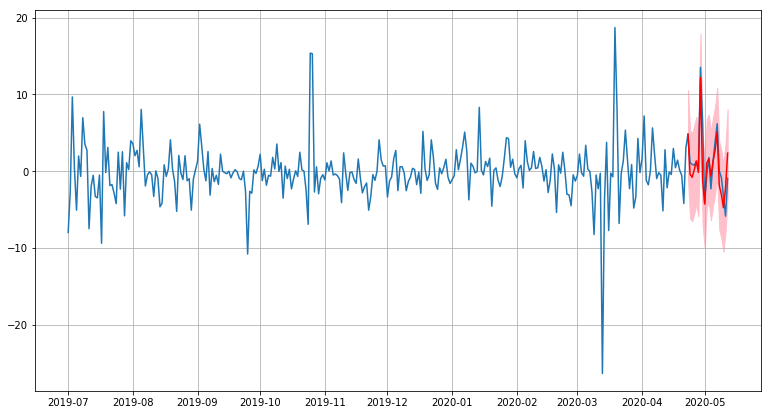

2020-05-11   -2.202755
2020-05-12    2.351077
Freq: D, dtype: float64

In [23]:
# FORECASTING

# Compute forecast
pct_change_forecast_d = pct_results_daily.get_prediction(start = -20)

# compute forecast mean
pct_change_mean_forecast_d = pct_change_forecast_d.predicted_mean

# Compute confidence intervals of mean_forecast
pct_confidence_intervals_d = pct_change_forecast_d.conf_int()

# Plot results: initialize figure
plt.figure(figsize = (13,7))

# Plot data
plt.plot(train_df_d.high.index, train_df_d.high, label = "observed")

# plot mean forecast
plt.plot(pct_change_mean_forecast_d.index, pct_change_mean_forecast_d, color='r', label='forecast')
plt.grid()

# shade the area between confidence limits
lower_limits = pct_confidence_intervals_d["lower high"]
upper_limits = pct_confidence_intervals_d["upper high"]

plt.fill_between(lower_limits.index, lower_limits,
		 upper_limits, color='pink')


plt.show()

start = "2020-05-11"
end = "2020-05-12"
pct_results_daily.predict(start = start, end = end, exog = dfd_pct_change_exog.iloc[0,:].values.reshape(1,2))

## FORECAST MODEL FOR WEEKLY BITCOIN PRICES

                 open       high        low      close     volume  market_cap  \
2017-01-08   4.471494   4.308872  -2.131309  -0.466780  98.432839   -0.419786   
2017-01-15 -15.626805 -17.236907 -13.141856 -15.791388 -45.241960  -15.720107   
2017-01-22   3.706363   4.451586   6.469719   6.988898 -21.385811    7.086753   
2017-01-29   3.638607   1.801311   4.674825   2.026920 -21.554685    2.115610   
2017-02-05   7.786579   8.929416   7.596398   9.354252  45.608818    9.448678   

            market_cap/volume  
2017-01-08         -42.614026  
2017-01-15          68.136674  
2017-01-22          20.560746  
2017-01-29          28.999999  
2017-02-05         -26.396142  


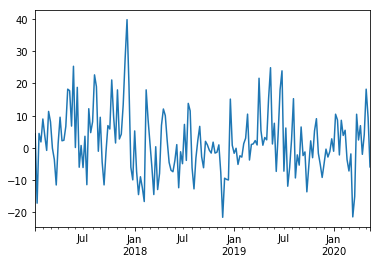

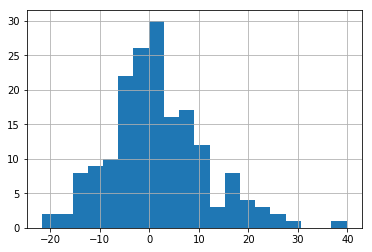

Augmented Dickey-Fuller test on percentage change (weekly data):  4.1492778720293934e-15


In [24]:
# MODEL FOR WEEKLY DATA

# Create dataframe for weekly data with percentage change data 
dfw_pct_change = dfw.resample("W").mean().pct_change().dropna()*100

# Print head of dataframe
print(dfw_pct_change.head())

# Plot data to see if it looks stationary
dfw_pct_change.high.plot()
plt.show()
dfw_pct_change.high.hist(bins = 20)
plt.show()
# Perform Augmented Dickey-Fuller test 
pct_change_res = adfuller(dfw_pct_change.high)

# Print results 
print("Augmented Dickey-Fuller test on percentage change (weekly data): ",pct_change_res[1])


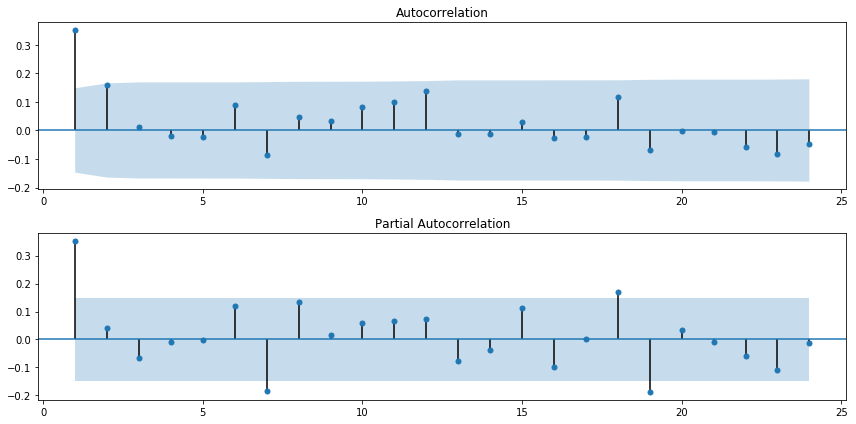

In [35]:
# Check for autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,6))
plot_acf(dfw_pct_change.high, lags = 24, zero = False, ax = ax1)
plot_pacf(dfw_pct_change.high, lags = 24, zero = False, ax = ax2)
plt.tight_layout()
plt.show()

In [26]:
# Define exogenous data in function of percentage change 
dfw_pct_change_exog = dfw_pct_change[["market_cap","volume"]]

# Print tail of exogenous data
print(dfw_pct_change_exog.tail())






            market_cap     volume
2020-04-19   -1.512051  -9.503079
2020-04-26    4.402128  -0.136292
2020-05-03   17.107963  32.327016
2020-05-10    9.300037  10.128610
2020-05-17   -6.705903  -3.768442


In [38]:
# Loop over p values from 0-2

pct_order_aic_bic = []
            
for p in range(0,7):
    # Loop over q values from 0-2
    for q in range(0,7):

        try:
            # create and fit SARIMAX(p,1,q) model
            pct_model = sm.tsa.statespace.SARIMAX(dfw_pct_change.high, order=(p,1,q), exog = dfw_pct_change_exog)
            
            pct_results = pct_model.fit()
            
            pct_mae = np.mean(np.abs(pct_results.resid))

            # Print order and results
            pct_order_aic_bic.append((p, q, pct_results.aic, pct_results.bic, pct_mae))

        except:
            pct_order_aic_bic.append((p, q, None, None))

aic_bic_df = pd.DataFrame(pct_order_aic_bic, 
                        columns=['p','q','AIC','BIC', "mae"])

print("Sorted by mae")
print(aic_bic_df.sort_values("mae"))


/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to conv

Sorted by mae
    p  q         AIC         BIC       mae
27  3  6  612.636002  650.613434  0.953959
26  3  5  606.979850  641.792496  0.956308
45  6  3  610.383748  648.361180  0.957289
13  1  6  611.248667  642.896527  0.957622
17  2  3  607.104261  632.422548  0.960454
10  1  3  605.418420  627.571922  0.962776
12  1  5  610.009056  638.492130  0.964262
29  4  1  611.284473  636.602761  0.965732
20  2  6  614.212098  649.024743  0.966143
22  3  1  611.199596  633.353097  0.967189
15  2  1  609.286736  628.275451  0.967264
34  4  6  612.375301  653.517519  0.967488
19  2  5  611.725662  643.373522  0.968220
33  4  5  609.934800  647.912232  0.968481
6   0  6  609.754730  638.237804  0.968577
31  4  3  611.426989  643.074848  0.968780
38  5  3  613.493809  648.306455  0.969838
18  2  4  614.183110  642.666183  0.973295
44  6  2  613.657419  648.470065  0.973380
36  5  1  611.408890  639.891964  0.973627
25  3  4  617.457678  649.105538  0.976780
32  4  4  613.462147  648.274793  0.9774

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA (2,1) MODEL
                           Statespace Model Results                           
Dep. Variable:                   high   No. Observations:                  176
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -298.437
Date:                Wed, 13 May 2020   AIC                            610.873
Time:                        13:50:42   BIC                            633.027
Sample:                    01-08-2017   HQIC                           619.859
                         - 05-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
market_cap     0.9328      0.009    106.560      0.000       0.916       0.950
volume         0.0448      0.003     12.895      0.000       0.038       0.052
ar.L1         -1.3386      0.060   

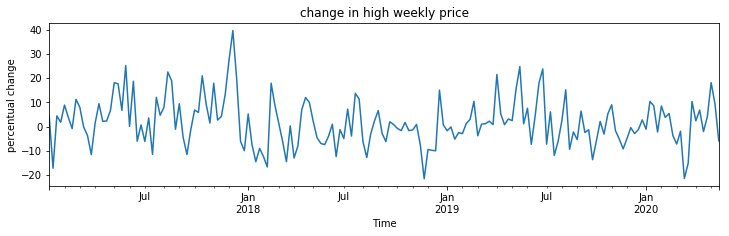

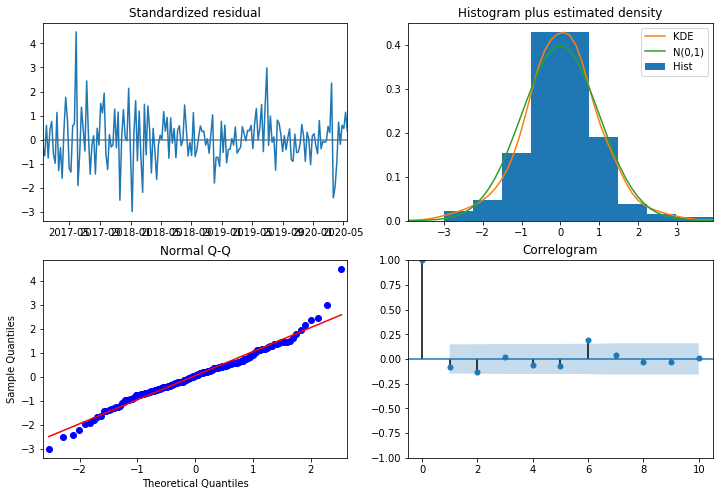

In [37]:
# IMPLEMENTATION OF FINAL MODEL FOR FORECASTING CHANGE

# Define "p" and "q" for the final model
res = aic_bic_df.sort_values("mae").iloc[0,0:2].values

p = int(res[0])
q = int(res[1])

print("ARMA ({},{}) MODEL".format(p,q))

modelw = sm.tsa.statespace.SARIMAX(dfw_pct_change.high, dfw_pct_change_exog, order=(p_finalmodel,1,q_finalmodel))
            
resultsw = modelw.fit(disp = False, maxiter=200)
print(resultsw.summary())
            
maew = np.mean(np.abs(resultsw.resid))

print("mae: ", maew)

dfw_pct_change.high.plot(figsize = (12,3))
plt.title("change in high weekly price")
plt.ylabel("percentual change")
plt.xlabel("Time")
plt.show()

resultsw.plot_diagnostics(figsize=(12,8))
plt.show()


            lower high  upper high
2020-01-05   -3.978889    1.143246
2020-01-12    8.181584   13.303330
2020-01-19    6.835098   11.956844
2020-01-26   -5.843550   -0.722185
2020-02-02    6.467986   11.589351


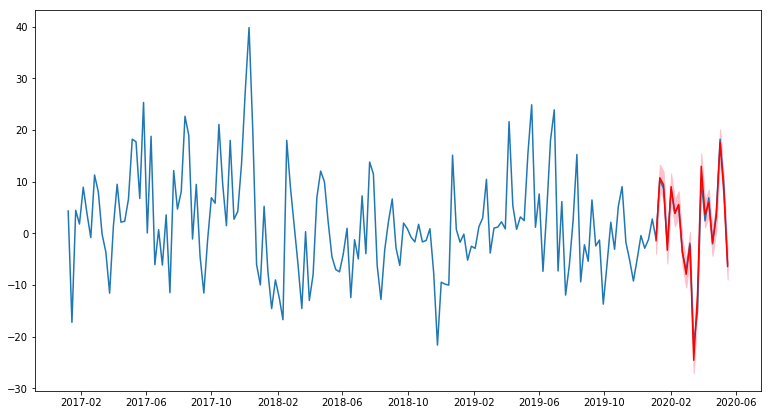

In [29]:
# FORECASTING

# Compute forecast
pct_change_forecast = resultsw.get_prediction(start = -20)

# compute forecast mean
pct_change_mean_forecast = pct_change_forecast.predicted_mean

# Compute confidence intervals of mean_forecast
pct_confidence_intervals = pct_change_forecast.conf_int()
print(pct_confidence_intervals.head())

# Plot results: initialize figure
plt.figure(figsize = (13,7))

# Plot data
plt.plot(dfw_pct_change.index, dfw_pct_change.high, label = "observed")

# plot mean forecast
plt.plot(pct_change_mean_forecast.index, pct_change_mean_forecast, color='r', label='forecast')

# shade the area between confidence limits
lower_limits = pct_confidence_intervals["lower high"]
upper_limits = pct_confidence_intervals["upper high"]

plt.fill_between(lower_limits.index, lower_limits,
		 upper_limits, color='pink')


plt.show()

In [40]:
# print forecast on one week ahead 
start = "2020-05-10"
end = "2020-05-17"
print(resultsw.predict(start = start, end = end, exog = dfw_pct_change_exog.iloc[0].values.reshape(1,2)))
dfw_pct_change.tail()

2020-05-10    7.972512
2020-05-17   -6.422872
Freq: W-SUN, dtype: float64


,open,high,low,close,volume,market_cap,market_cap/volume
2020-04-19,-1.700523,-2.053866,-1.434289,-1.587785,-9.503079,-1.512051,8.810170
2020-04-26,3.809172,4.071405,4.543512,4.328017,-0.136292,4.402128,3.704561
2020-05-03,15.771776,18.204383,15.763085,17.028338,32.327016,17.107963,-8.030253
2020-05-10,11.670997,9.459581,9.149195,9.221911,10.128610,9.300037,-3.793830
2020-05-17,-7.128601,-5.958250,-6.386666,-6.745886,-3.768442,-6.705903,-2.304912


## WEBSCRAPING WORKSHOP

Up to now, the model is working under historical data. This means that now the forecast possibilities are rather limited, since most current data is from yesterday. By webscraping on updated data, we can add this collected data into the dataframe.


In [31]:
import requests
from bs4 import BeautifulSoup
import urllib.request
from lxml import html

today = str(date.today())

url_current_bcprice = "https://www.coindesk.com/price/bitcoin"
xpath_bc_currprice = '/html/body/div/main/section/div[2]/div[1]/div/section/div/div/section[1]/div/dl[1]/dd'

response = requests.get(url_current_bcprice)
soup = BeautifulSoup(response.content)
#print(BeautifulSoup.prettify(soup))

mydivs = soup.find("div", {"class": "pricing"})
print(mydivs)


<div class="pricing"><div class="price val-negative"><span class="symbol">$</span>0</div><div class="change-percent val-negative">NaN%</div></div>
